# Neural graph learning on CiteSeer dataset

## Introduction to the dataset

The [Citeseer dataset](https://linqs.soe.ucsc.edu/data) consists of two parts - 3312 scientific publications and a graph structure.
Each publication has an Id, one-hot representaiton of word attributes and a label indicating the type of publication. The publications are classified into one of six categories. Theres is a total of 3703 unique words in the vocabulary. Removing stopwords, stemming and removal of infrequent words was already done to the dataset.
In the graph data each node is a publication and a link is formed between the nodes when one has citet the other.

In our experiment we consider the graph to be bidirectional as the the graph is considered a measure of similarity between the papers and the direction of the link does not offer additional insight.

To read more about other papers that used the same dataset, see [Qing Lu, and Lise Getoor. "Link-based classification." ICML, 2003.](https://linqspub.soe.ucsc.edu/basilic/web/Publications/2003/lu:icml03/) and  [Prithviraj Sen, et al. "Collective classification in network data." AI Magazine, 2008.](https://linqspub.soe.ucsc.edu/basilic/web/Publications/2008/sen:aimag08/).

No additional preprocessing was done to the dataset. The original dataset can be downloaded [here](https://linqs-data.soe.ucsc.edu/public/lbc/citeseer.tgz).

Dataset summary:
* 3703 unique word attributes
* 3312 scientific publications
* Labels for classifying the papers are:
    * Agents
    * AI
    * DB
    * IR
    * ML
    * HCI
* Each publication can have only one label.

## Experiment

The goal is to correctly classify the paper cateogry and examine the performance difference between the Neural Graph Learning model and a base model.

To proberly examine the performance difference between the models, each model is trainined with traning sizes from 0.1 to 0.85 with 0.5 incrementes. The models is run 5 times at each traning sizes whereafter the average results are presented in a graph.

## References

Large parts of the code for preprocessing, loading train, test and validation data, evaluation, generation of Keras functional models is modefied from Tensorflows tutorials and resources introducing neural structed learning. The original code can be found here: [Tensorflows github](https://github.com/tensorflow/neural-structured-learning) and [Guide and Tutorials](https://www.tensorflow.org/neural_structured_learning/framework).
Furthermore, additional information about the API can be found [here](https://www.tensorflow.org/neural_structured_learning/api_docs/python/nsl).

# Experiment

### Importing needed libraries

In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals
import neural_structured_learning as nsl
import tensorflow as tf
import csv
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
import warnings
warnings.filterwarnings('ignore')

### Getting the data

In [13]:
!tar -C /tmp -xvzf /Users/johanweisshansen/Documents/DTU/3.semester/advanced_project/oticon_project/terror_data/nsl/dataset_test_6/citeseer/citeseer.tgz

x citeseer/
x citeseer/citeseer.content
x citeseer/README
x citeseer/citeseer.cites


### Defining hyperparameters

In [31]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 6
    self.max_seq_length = 3703 # distinct features
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 1
    ### model architecture
    self.num_fc_units = [50,50]
    ### training parameters
    self.train_epochs = 150
    self.batch_size = 150
    self.dropout_rate = 0.5
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

### Load train and test data

In [46]:
def parse_example(example_proto):

    feature_spec = {
        'words':
            tf.io.FixedLenFeature([HPARAMS.max_seq_length],
                                tf.int64,
                                default_value=tf.constant(
                                    0,
                                    dtype=tf.int64,
                                    shape=[HPARAMS.max_seq_length])),
        'label':
          tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
  # the features above.
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format('NL_nbr_', i, 'words')
        nbr_weight_key = '{}{}{}'.format('NL_nbr_', i, '_weight')
        feature_spec[nbr_feature_key] = tf.io.FixedLenFeature(
            [HPARAMS.max_seq_length],
            tf.int64,
            default_value=tf.constant(
            0, dtype=tf.int64, shape=[HPARAMS.max_seq_length]))

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    labels = features.pop('label')
    return features, labels


def make_dataset(file_path, training=False):
     #Creates a `tf.data.TFRecordDataset`.

    dataset = tf.data.TFRecordDataset([file_path])
    if training:
        dataset = dataset.shuffle(10000)
    dataset = dataset.map(parse_example)
    dataset = dataset.batch(HPARAMS.batch_size)
    return dataset

### Functional base model from Keras API

In [43]:
def functional_model(hparams):
    """Creates a functional API-based multi-layer perceptron model."""
    inputs = tf.keras.Input(shape=(hparams.max_seq_length,), dtype='int64', name='words')

  # casting one hot to floating point format.
    cur_layer = tf.keras.layers.Lambda(
      lambda x: tf.keras.backend.cast(x, tf.float32))(
          inputs)

    for num_units in hparams.num_fc_units:
        cur_layer = tf.keras.layers.Dense(num_units, activation='relu')(cur_layer)
        cur_layer = tf.keras.layers.Dropout(hparams.dropout_rate)(cur_layer)
        cur_layer = tf.keras.layers.BatchNormalization()(cur_layer)

    outputs = tf.keras.layers.Dense(
      hparams.num_classes, activation='softmax')(
          cur_layer)

    model = tf.keras.Model(inputs, outputs=outputs)
    return model

### Function to evaluate models

In [35]:
# Helper function to print evaluation metrics.
def print_metrics(model_desc, eval_metrics):
    print('\n')
    print('Eval accuracy for ', model_desc, ': ', eval_metrics['accuracy'])
    print('Eval loss for ', model_desc, ': ', eval_metrics['loss'])
    if 'graph_loss' in eval_metrics:
        print('Eval graph loss for ', model_desc, ': ', eval_metrics['graph_loss'])

### Function for training base model

In [44]:
def traning_base_model(train_dataset):
    base_model = functional_model(HPARAMS)

    base_model.compile(
        optimizer='adam',
        #sparse_categorical_crossentropy
        #categorical_crossentropy
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        lr=0.01, clipnorm=1.)
    base_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=0)
    
    return base_model

### Function for traning graph model

In [47]:
def training_graph_model(train_dataset):
    # Build a new base MLP model.
    base_reg_model = functional_model(HPARAMS)
    
    # Wrap the base MLP model with graph regularization.
    graph_reg_config = nsl.configs.make_graph_reg_config(
        max_neighbors=HPARAMS.num_neighbors,
        multiplier=HPARAMS.graph_regularization_multiplier,
        distance_type=HPARAMS.distance_type,
        sum_over_axis=-1)
    graph_reg_model = nsl.keras.GraphRegularization(base_reg_model, graph_reg_config)
    
    graph_reg_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    graph_reg_history = graph_reg_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=0)
    
    return graph_reg_model

In [48]:
def generateTrainingData(train_percent):
        # running the data trough the preprocessing script
    !python preprocessing_citeseer_dataset.py \
    --input_content=/tmp/citeseer/citeseer.content \
    --input_graph=/tmp/citeseer/citeseer.cites \
    --max_nbrs=3 \
    --train_percentage=$train_percent\
    --output_train_data=/tmp/citeseer/train_merged_examples.tfr \
    --output_test_data=/tmp/citeseer/test_examples.tfr
    
        # generating train and test data
    train_dataset = make_dataset('/tmp/citeseer/train_merged_examples.tfr', training=True)
    test_dataset = make_dataset('/tmp/citeseer/test_examples.tfr')
    
    return train_dataset, test_dataset

### Iterating over training size

In [49]:
# defining the training size we need to iterate over
train_percentage = []
train_percentage.append(0.01) # starting the list at 1% of training data

for i in np.arange(0.05, 0.9, 0.05):
    train_percentage.append(round(i,2))

In [ ]:
# lists for holding results
graph_accuracy_by_training_size_avg = []
base_accuracy_by_training_size_avg = []

for j in range(5):
    
    print("----------------------------- iteration: ", j+1, "------------------------" )
    base_model_results_list = []
    graph_model_results_list = []

    for i in range(len(train_percentage)):

        print("---------------------training at percentage ", train_percentage[i], "--------------------------------")
        # creating test and training data
        train_dataset, test_dataset = generateTrainingData(train_percentage[i])

        # creating and training the base model
        base_model = traning_base_model(train_dataset)

        # evaluate base model
        eval_results = dict(
        zip(base_model.metrics_names,
            base_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
        print_metrics('Base MLP model', eval_results)

        # adding results to a list
        base_model_results_list.append(eval_results)


        # creating and training the graph model
        graph_model = training_graph_model(train_dataset)

        # evaluating the model
        eval_results_graph_regulated_model = dict(
        zip(graph_model.metrics_names,
            graph_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
        print_metrics('MLP + graph regularization', eval_results_graph_regulated_model)

        # adding the graph results to a list 
        graph_model_results_list.append(eval_results_graph_regulated_model)
        

    graph_accuracy_by_training_size_avg.append(graph_model_results_list)
    base_accuracy_by_training_size_avg.append(base_model_results_list)

----------------------------- iteration:  1 ------------------------
---------------------training at percentage  0.01 --------------------------------
preprocessing_citeseer_dataset.py:98: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.01 seconds). Total graph nodes: 3327
Joining seed and neighbor tf.train.Examples with graph edges...
Done creating and writing 41 merged tf.train.Examples (0.04 seconds).
Out-degree histogram: [(1, 18), (2, 9), (3, 14)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.06 minutes.
22/22 [==============================] - 0s 19ms/step - loss: 1.8233 - accuracy: 0.2440


Eval accuracy for  Base MLP model :  0.24

Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.07 minutes.
17/17 [==============================] - 0s 20ms/step - loss: 1.1962 - accuracy: 0.6744


Eval accuracy for  Base MLP model :  0.6744373
Eval loss for  Base MLP model :  1.1962108366629656
17/17 [==============================] - 1s 34ms/step - loss: 1.3641 - accuracy: 0.6813 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.6812701
Eval loss for  MLP + graph regularization :  1.3641218998852898
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.3 --------------------------------
preprocessing_citeseer_dataset.py:98: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cite

13/13 [==============================] - 0s 38ms/step - loss: 1.5262 - accuracy: 0.7139 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.7138935
Eval loss for  MLP + graph regularization :  1.5261953794039214
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.5 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.00 seconds). Total graph nodes: 3327
Joining seed and neighbor tf.train.Examples with graph edges...
W1210 20:37:09.429082 4668186048 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "ghani01hypertext"
W1210 20:37:09.574671 4668186048 preprocessing_citeseer_dataset.py:104] No tf.train.Exam

W1210 20:41:31.021565 4363668928 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "flach99database"
W1210 20:41:31.051138 4363668928 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "95786"
W1210 20:41:31.143206 4363668928 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
W1210 20:41:31.266033 4363668928 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
Done creating and writing 2153 merged tf.train.Examples (2.01 seconds).
Out-degree histogram: [(1, 879), (2, 512), (3, 762)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.09 minutes.
8/8 [==============================] - 0s 29ms/step - loss: 1.3965 - accuracy: 0.7213


Eval accuracy for  Base MLP model :  0.72131145
Eval

W1210 20:46:46.495829 4359957952 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
W1210 20:46:46.655400 4359957952 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
W1210 20:46:46.690980 4359957952 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "293457"
W1210 20:46:46.691066 4359957952 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "gabbard97taxonomy"
Done creating and writing 2634 merged tf.train.Examples (2.42 seconds).
Out-degree histogram: [(1, 1082), (2, 636), (3, 916)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.09 minutes.
5/5 [==============================] - 0s 39ms/step - loss: 1.5572 - accuracy: 0.7227


Eval accuracy for  Base MLP model :  0.7227139
E

20/20 [==============================] - 1s 29ms/step - loss: 1.1991 - accuracy: 0.6108 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.6108491
Eval loss for  MLP + graph regularization :  1.199131715297699
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.15 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.00 seconds). Total graph nodes: 3327
Joining seed and neighbor tf.train.Examples with graph edges...
W1210 20:52:13.308389 4485696960 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
Done creating and writing 505 merged tf.train.Examples (0.45 seconds).
Out-degree histogra

Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.08 minutes.
15/15 [==============================] - 0s 19ms/step - loss: 1.3050 - accuracy: 0.7005


Eval accuracy for  Base MLP model :  0.70051235
Eval loss for  Base MLP model :  1.3050384084383646
15/15 [==============================] - 1s 33ms/step - loss: 1.3954 - accuracy: 0.7145 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.71448535
Eval loss for  MLP + graph regularization :  1.3954192082087198
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.4 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.00 seconds). Total graph 

W1210 21:00:19.279496 4685987264 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
Done creating and writing 1807 merged tf.train.Examples (1.65 seconds).
Out-degree histogram: [(1, 743), (2, 428), (3, 636)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.08 minutes.
11/11 [==============================] - 0s 29ms/step - loss: 1.2610 - accuracy: 0.7276


Eval accuracy for  Base MLP model :  0.72757477
Eval loss for  Base MLP model :  1.2610104029828852
11/11 [==============================] - 0s 42ms/step - loss: 1.4906 - accuracy: 0.7382 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.73820597
Eval loss for  MLP + graph regularization :  1.4906040755185215
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.6 ----

preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.01 seconds). Total graph nodes: 3327
Joining seed and neighbor tf.train.Examples with graph edges...
W1210 21:06:37.543995 4664176064 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "197556"
W1210 21:06:37.554171 4664176064 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "ghani01hypertext"
W1210 21:06:37.763429 4664176064 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "nielsen00designing"
W1210 21:06:37.828196 4664176064 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
W1210 21:06:37.836631 4664176064 preprocessing_citeseer_d

Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.10 minutes.
4/4 [==============================] - 0s 41ms/step - loss: 1.5910 - accuracy: 0.7495


Eval accuracy for  Base MLP model :  0.749499
Eval loss for  Base MLP model :  1.590956062078476
4/4 [==============================] - 0s 93ms/step - loss: 1.4328 - accuracy: 0.7695 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.76953906
Eval loss for  MLP + graph regularization :  1.432834953069687
Eval graph loss for  MLP + graph regularization :  0.0
----------------------------- iteration:  3 ------------------------
---------------------training at percentage  0.01 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making

W1210 21:15:24.868649 4798598592 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "nielsen00designing"
W1210 21:15:24.953765 4798598592 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
W1210 21:15:24.988554 4798598592 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
Done creating and writing 824 merged tf.train.Examples (0.76 seconds).
Out-degree histogram: [(1, 359), (2, 190), (3, 275)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.07 minutes.
17/17 [==============================] - 0s 19ms/step - loss: 1.2046 - accuracy: 0.6837


Eval accuracy for  Base MLP model :  0.68368167
Eval loss for  Base MLP model :  1.2045855066355537
17/17 [==============================] - 1s 34ms/step - loss: 1.3482 - acc

Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.08 minutes.
13/13 [==============================] - 0s 22ms/step - loss: 1.2969 - accuracy: 0.7117


Eval accuracy for  Base MLP model :  0.71169686
Eval loss for  Base MLP model :  1.296915407364185
13/13 [==============================] - 0s 38ms/step - loss: 1.5818 - accuracy: 0.7172 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.71718836
Eval loss for  MLP + graph regularization :  1.5817886957755456
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.5 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cit

W1210 21:25:21.522842 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "nielsen00designing"
W1210 21:25:21.580905 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "weng95shoslifn"
W1210 21:25:21.600841 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "khardon99relational"
W1210 21:25:21.647770 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "flach99database"
W1210 21:25:21.678167 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "95786"
W1210 21:25:21.769394 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
W1210 21:25:21.893530 4420914624 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
Done creating and writing 2153 merged tf.train.Ex

W1210 21:31:00.279674 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "flach99database"
W1210 21:31:00.319864 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "95786"
W1210 21:31:00.389474 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "kohrs99using"
W1210 21:31:00.435483 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
W1210 21:31:00.598766 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
W1210 21:31:00.638522 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "293457"
W1210 21:31:00.638655 4391230912 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "gabbard97taxonomy"
Done creating and writing 2634 merged tf.train.Examples (2.62 sec

Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.07 minutes.
20/20 [==============================] - 0s 18ms/step - loss: 1.1804 - accuracy: 0.5893


Eval accuracy for  Base MLP model :  0.58928573
Eval loss for  Base MLP model :  1.180387595295906
20/20 [==============================] - 1s 31ms/step - loss: 1.2391 - accuracy: 0.5997 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.59973043
Eval loss for  MLP + graph regularization :  1.2391351968050004
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.15 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.01 seconds). Total graph 

Done creating and writing 1165 merged tf.train.Examples (1.10 seconds).
Out-degree histogram: [(1, 503), (2, 268), (3, 394)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.08 minutes.
15/15 [==============================] - 0s 21ms/step - loss: 1.3477 - accuracy: 0.6903


Eval accuracy for  Base MLP model :  0.6902655
Eval loss for  Base MLP model :  1.347720444202423
15/15 [==============================] - 1s 35ms/step - loss: 1.4353 - accuracy: 0.7075 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.70749885
Eval loss for  MLP + graph regularization :  1.4352906942367554
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.4 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as ci

W1210 21:45:42.939401 4416781760 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "tobies99pspace"
W1210 21:45:43.041807 4416781760 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "raisamo99evaluating"
Done creating and writing 1807 merged tf.train.Examples (1.66 seconds).
Out-degree histogram: [(1, 743), (2, 428), (3, 636)]
Output training data written to TFRecord file: /tmp/citeseer/train_merged_examples.tfr.
Output test data written to TFRecord file: /tmp/citeseer/test_examples.tfr.
Total running time: 0.08 minutes.
11/11 [==============================] - 0s 22ms/step - loss: 1.2897 - accuracy: 0.7196


Eval accuracy for  Base MLP model :  0.71960133
Eval loss for  Base MLP model :  1.289697896350514
11/11 [==============================] - 0s 44ms/step - loss: 1.4083 - accuracy: 0.7355 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.7355482
Eval loss for  MLP + graph regularizati

7/7 [==============================] - 0s 66ms/step - loss: 1.4691 - accuracy: 0.7651 - graph_loss: 0.0000e+00


Eval accuracy for  MLP + graph regularization :  0.76506025
Eval loss for  MLP + graph regularization :  1.4691139033862524
Eval graph loss for  MLP + graph regularization :  0.0
---------------------training at percentage  0.75 --------------------------------
preprocessing_citeseer_dataset.py:75: DeprecationWarning: 'U' mode is deprecated
  with open(in_file, 'rU') as citeseer_content:
Reading graph file: /tmp/citeseer/citeseer.cites...
Done reading 4732 edges from: /tmp/citeseer/citeseer.cites (0.01 seconds).
Making all edges bi-directional...
Done (0.01 seconds). Total graph nodes: 3327
Joining seed and neighbor tf.train.Examples with graph edges...
W1210 21:52:27.005534 4615777728 preprocessing_citeseer_dataset.py:104] No tf.train.Example found for edge target ID: "197556"
W1210 21:52:27.017549 4615777728 preprocessing_citeseer_dataset.py:104] No tf.train.Example found 

# Results

To get at better idea of the difference in learning at different training sizes we substract the two model preformances from each other.

A postive value indicates a gain for the graph based model over the base model.

In [38]:
graph_avg_list = []
base_avg_list = []

for i in range(0,len(graph_accuracy_by_training_size_avg[0])):
    tmp_avg_value = 0
    for j in range(0,len(graph_accuracy_by_training_size_avg)):
        tmp_avg_value += graph_accuracy_by_training_size_avg[j][i]['accuracy']
    graph_avg_list.append(tmp_avg_value/5)
    
for i in range(0,len(base_accuracy_by_training_size_avg[0])):
    tmp_avg_value = 0
    for j in range(0,len(base_accuracy_by_training_size_avg)):
        tmp_avg_value += base_accuracy_by_training_size_avg[j][i]['accuracy']
    base_avg_list.append(tmp_avg_value/5)

In [39]:
diff_graph_and_basemodel = []

for i in range(len(base_avg_list)):
    diff_graph_and_basemodel.append(graph_avg_list[i]- base_avg_list[i])

In [40]:
collected_list = []
collected_list.append(base_avg_list)
collected_list.append(graph_avg_list)
collected_list.append(diff_graph_and_basemodel)

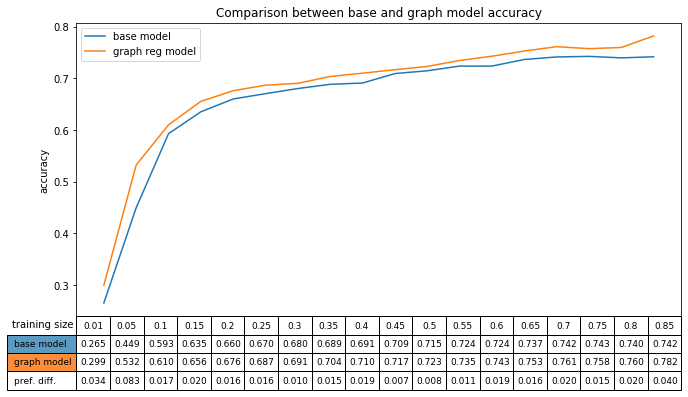

In [42]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

columns = train_percentage
rows = ['base model', 'graph model', 'pref. diff.']

# Get some pastel shades for the colors
n_rows = len(collected_list)

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(train_percentage))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    y_offset = collected_list[row]
    cell_text.append(['%1.3f' % x for x in y_offset])

# Add a table at the bottom of the axes
table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      rowColours=['#5b9ac4', '#fd8e39', '#ffffff'],
                      loc='bottom')

table.set_fontsize(14)

# table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1.7)
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)


# plt.plot(graph_collected)
plt.plot(base_avg_list)
plt.plot(graph_avg_list)

# plt.ylabel("Loss in ${0}'s".format(value_increment))
# plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Comparison between base and graph model accuracy')
plt.ylabel('accuracy')
# plt.xlabel('training size')
plt.annotate('training size', xy=(1,0), xytext=(-669, -3), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.legend(['base model', 'graph reg model'], loc='upper left')
plt.savefig('plots/citseer_accuracy_graph.png', bbox_inches='tight', pad_inches=0.1)

plt.show()